Pobranie niezbędnych bibliotek

In [1]:
import pandas as pd
import string 
import os
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import random
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

#library used to count the frequency of words
from sklearn.feature_extraction.text import CountVectorizer
#nltk.download('stopwords')
#nltk.download('wordnet') 
#nltk.download('omw-1.4')

Pobranie tekstów piosenek, sprawdzanie danych z jakimi mamy do czynienia

In [35]:
df=pd.read_csv('C:/Users/szwac/Documents/Data science/IV semestr/Eksploracja danych tekstowych - lab/projekt/Metallica_songs.csv', sep=';')
df.sample(5)

,Song,Author_band,Songwriters,Duration,Album,Album_type,No_on_album,Release_date,Link,Lyrics
175,Spit Out the Bone,Metallica,"James Hetfield,Lars Ulrich",7:09,Hardwired... to Self-Destruct,Album,12.0,2016-11-18,https://www.metallica.com/songs/spit-out-the-b...,"Come unto me and you will feel perfection,Come..."
153,Prince Charming,Metallica,"James Hetfield,Lars Ulrich",6:05,Reload,Album,10.0,1997-11-18,https://www.metallica.com/songs/prince-charmin...,"There’s a black cloud overhead,That’s me,And t..."
6,All Within My Hands,Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett,Bob Rock",8:48,St. Anger,Album,11.0,2003-06-05,https://www.metallica.com/songs/all-within-my-...,"All within my hands,Squeeze it in crush it dow..."
192,The Train Kept-A-Rollin’,Tiny Bradshaw,"Tiny Bradshaw,Lois Mann,Howard Kay",NaN,NaN,NaN,NaN,NaN,https://www.metallica.com/songs/the-train-kept...,"I caught a train met a dame,She was a hipster ..."
11,(Anesthesia) - Pulling Teeth,Metallica,Cliff Burton,4:14,Kill 'Em All,Album,5.0,1983-07-25,https://www.metallica.com/songs/anesthesia-pul...,Instrumental


Usunięcie zbędnych kolumn

In [36]:
df = df.drop(columns=['Songwriters', 'Duration' ,'Album', 'Album_type', 'No_on_album','Release_date', 'Link', 'Songwriters'])
df.head(5)

,Song,Author_band,Lyrics
0,2 x 4,Metallica,"I’m gonna make you shake you take you,I’m gonn..."
1,53rd & 3rd,The Ramones,"If you think you can well come on man,I was a ..."
2,72 Seasons,Metallica,"Feeding on the wrath of man,Shot down,Traumati..."
3,Ain’t My Bitch,Metallica,"Outta my way,Outta my day,Out of your mind and..."
4,All Day and All of the Night,The Kinks,"I’m not content to be with you in the daytime,..."


Przygotowanie niezbędnych funkcji

In [15]:
def clean_lyrics(df,column):
    #Funkcja usuwa didaskalia i przygotowuje tekst do dalszej obróbki 
    
    df['Lyrics'] = df['Lyrics'].str.lower()
    df['Lyrics'] = df['Lyrics'].str.replace(r"verse |[1|2|3]|chorus|bridge|outro"," ").str.replace("["," ").str.replace("]"," ")
    df['Lyrics'] = df['Lyrics'].str.lower().str.replace(r"instrumental|intro|guitar|solo","")
    df['Lyrics'] = df['Lyrics'].str.replace("\n"," ").str.replace(r"[^\w\d'\s]+"," ").str.replace("efil ym fo flah"," ")
    df['Lyrics'] = df['Lyrics'].str.strip()

    return df

def lyrics_to_words(document):
    #Funkcja dzieli tekst na pojedyncze słowa i normalizuje tekst
  
    stop_words = set(stopwords.words('english'))
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()
    stopwordremoval = " ".join([i for i in document.lower().split() if i not in stop_words])
    punctuationremoval = ''.join(ch for ch in stopwordremoval if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punctuationremoval.split())
    return normalized

In [38]:
df_cleaned = clean_lyrics(df,'Lyrics')
df = df[df['Lyrics'].notnull()]
df_cleaned.sample(5)

,Song,Author_band,Lyrics
145,The Other New Song,Metallica,see the vultures come see the vultures come fo...
101,Justice Medley,Metallica,opposition contradiction premonition compromis...
140,Now That We’re Dead,Metallica,when darkness falls may it be that we should s...
185,The Thing That Should Not Be,Metallica,messenger of fear in sight dark deception kill...
9,Am I Savage?,Metallica,ooooh run away the past will bite again ooooh ...


Ze zbioru utworów usuwam covery.

In [39]:
df_cleaned2 = df_cleaned[df_cleaned['Author_band'] == 'Metallica']
df_cleaned2.to_csv('C:/Users/szwac/Documents/Data science/IV semestr/Eksploracja danych tekstowych - lab/projekt/teksty.csv',index=False)
df_cleaned2.sample(5)

,Song,Author_band,Lyrics
109,Little Dog,Metallica,little dog who can t get in moaning at the bed...
157,Rebel of Babylon,Metallica,rebel grip your bottle tight just float away r...
168,Shoot Me Again,Metallica,i won t go away right here i ll stay stand s...
115,Mama Said,Metallica,mama she has taught me well told me when i was...
11,(Anesthesia) - Pulling Teeth,Metallica,


In [40]:
def unique(list1):
   #pusta lista
     unique_list = []
   #przejdź przez listę
     for x in list1:
         #sprawdź czy występuje w unique_list
         if x not in unique_list:
              unique_list.append(x)
     return unique_list

In [42]:
#Przechowuje unikalne słowa wszystkich piosenek w nowej kolumnie 'words'

#lista do przechowywania słów
words = []

#iteracja przez wszystkie teksty i dzieli unikalne słowa dodając je do listy słów
df_cleaned2 = df_cleaned2.reset_index(drop=True)
for word in df_cleaned2['Lyrics'].tolist():
    words.append(unique(lyrics_to_words(word).split()))
    
#dodaj zebrane słowa do kolumny 'words'
df_cleaned2['words'] = words
df_cleaned2.head()

,Song,Author_band,Lyrics,words
0,2 x 4,Metallica,i m gonna make you shake you take you i m gonn...,"[gonna, make, shake, take, one, break, put, sc..."
1,72 Seasons,Metallica,feeding on the wrath of man shot down traumati...,"[feeding, wrath, man, shot, traumatic, time, h..."
2,Ain’t My Bitch,Metallica,outta my way outta my day out of your mind and...,"[outta, way, day, mind, mine, one, step, time,..."
3,All Nightmare Long,Metallica,luck runs out crawl from the wreckage one ...,"[luck, run, crawl, wreckage, one, time, horrif..."
4,All Within My Hands,Metallica,all within my hands squeeze it in crush it dow...,"[within, hand, squeeze, crush, hold, dear, suf..."


In [43]:
#dodaję nową kolumnę, w której zawarta będzie informacja o liczbie wystąpień unikalnych słów
df_cleaned2['frequency'] = 0
df_cleaned2['frequency'] = df_cleaned2['frequency'].astype(int)
df = df_cleaned2

#puste listy
set_words = []
set_frequency = []

#tworzy listę słów z kolumny Lyrics i liczy liczbę wystąpień
for i in df.index:
    for word in df['words'].iloc[i]:
        set_words.append(word)
        set_frequency.append(df['frequency'].iloc[i])

#tworzy nowy data frame, który zawiera unikalne słowa i liczbę ich wystąpień
words_df = pd.DataFrame({'words':set_words,'frequency':set_frequency})

In [44]:
df.head()

,Song,Author_band,Lyrics,words,frequency
0,2 x 4,Metallica,i m gonna make you shake you take you i m gonn...,"[gonna, make, shake, take, one, break, put, sc...",0
1,72 Seasons,Metallica,feeding on the wrath of man shot down traumati...,"[feeding, wrath, man, shot, traumatic, time, h...",0
2,Ain’t My Bitch,Metallica,outta my way outta my day out of your mind and...,"[outta, way, day, mind, mine, one, step, time,...",0
3,All Nightmare Long,Metallica,luck runs out crawl from the wreckage one ...,"[luck, run, crawl, wreckage, one, time, horrif...",0
4,All Within My Hands,Metallica,all within my hands squeeze it in crush it dow...,"[within, hand, squeeze, crush, hold, dear, suf...",0


In [45]:
#Zbiór własnych stop_words wg potrzeb
stop_words = ['45','verse','im','get','1000','58','60','80','youre','youve',
               'guitar','solo','instrumental','intro','pre',"3","yo","yeah"]

#Policzy częstotliwość każdego ze słów z wyjątkiem tych z listy 'stop_words'          
cv = CountVectorizer(stop_words=stop_words)

#Stworzy dataframe o nazwie "data_cv" do przechowywania informacji o tym ile razy zostało użyte dane słowo
text_cv = cv.fit_transform(words_df['words'].iloc[:])
data_cv = pd.DataFrame(text_cv.toarray(),columns=cv.get_feature_names_out())
data_cv['frequency'] = words_df['frequency']

vect_words = data_cv.groupby('frequency').sum().T
vect_words = vect_words.reset_index(level=0).rename(columns ={'index':'words'})
vect_words = vect_words.rename_axis(columns='')

#Zapisze dane do plik
vect_words.to_csv('C:/Users/szwac/Documents/Data science/IV semestr/Eksploracja danych tekstowych - lab/projekt/words.csv',index=False)



In [46]:
words=pd.read_csv('C:/Users/szwac/Documents/Data science/IV semestr/Eksploracja danych tekstowych - lab/projekt/words.csv', sep=',')


In [47]:
words.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2828 entries, 0 to 2827
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   words   2828 non-null   object
 1   0       2828 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 44.3+ KB


In [48]:
words.rename(columns={'0': 'frequency'}, inplace=True)

# Sprawdzenie zmian
words.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2828 entries, 0 to 2827
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   words      2828 non-null   object
 1   frequency  2828 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 44.3+ KB


In [49]:
words_sorted = words.sort_values(by='frequency', ascending=False)
words_sorted.head(20)

,words,frequency
1395,life,57
1628,never,54
2457,take,53
2098,see,52
123,away,48
2538,time,48
429,come,47
1683,one,46
858,feel,45
2061,say,40


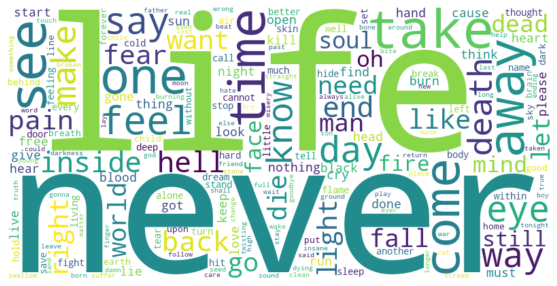

In [50]:
#tworzy słownik z df
word_freq = dict(zip(words_sorted['words'], words_sorted['frequency']))

font_path = 'C:/Windows/Fonts/arial.ttf'

# Generowanie chmury słów
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Wyświetlenie chmury słów
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [52]:
def words_stats(df,main_df):
    unique_words = []
    total_words = []
    total_news = []
    years = []
    for value in df.columns[1:]:
         unique_words.append(np.count_nonzero(df[value]))
         total_words.append(sum(df[value]))
         years.append(str(value))
         total_news.append(main_df['frequency'][main_df['frequency']==value].count())
    
    data = pd.DataFrame({'unique words':unique_words,'total words':total_words,'total songs':total_news})
    data['words per songs'] = round(data['total words'] / data['total songs'],0)
    data['words per songs'] = data['words per songs'].astype('int')
    return data


In [56]:
words_stats(vect_words,df)

,unique words,total words,total songs,words per songs
0,2828,8646,147,59


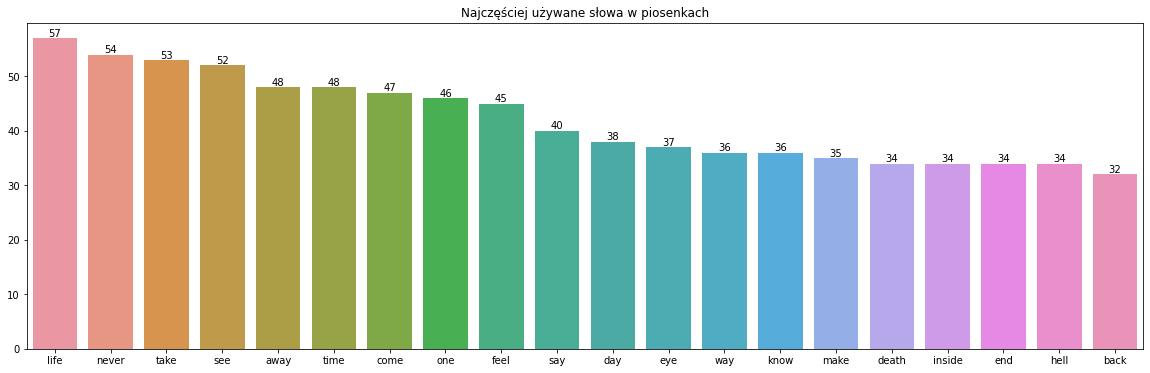

In [67]:
df_word_stats = pd.DataFrame(words_sorted.head(20))
plt.figure(figsize=(20, 6))
ax = sns.barplot(x='words', y='frequency', data=df_word_stats)

# Dodanie tytułu i etykiet osi
plt.title('Najczęściej używane słowa w piosenkach')
plt.xlabel('')
plt.ylabel('')

#Dodanie wartości nad słupkiem
for i in ax.containers:
    ax.bar_label(i,)

# Wyświetlenie wykresu
plt.show()